In [8]:
import numpy as np
import json
import geopandas as gpd
import pandas as pd
import xarray as xr
from affine import Affine
import rasterio as rio
from datetime import datetime
import matplotlib.pyplot as plt
import requests

In [9]:
########## USER ###########
# Select modeling domain ('WY', 'UT', 'OR', 'WA')
domain = 'WY'

# SM location 
SMpath = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhillWY'

# swe file no assim 
swe_base = SMpath + '_cso_id/outputs/wo_assim/swed.gdat'
swe_base_snotel = SMpath + '_snotel/outputs/wi_assim/swed_snotel.gdat'
swe_base_cso = SMpath + '_cso/outputs/wi_assim/swed_under20bias.gdat'
swe_corr = SMpath +'_cso/swe_assim/corr_factor2.gdat'

#all snotel 
gdf = gpd.read_file('/nfs/attic/dfh/Aragon2/CSOdata/'+domain+'/CSO_SNOTEL_sites.geojson')

#assim snotel
assimPath = '/nfs/attic/dfh/Aragon2/CSOassim/'+domain+'/'
assim_gdf = gpd.read_file(assimPath + 'assim_SNOTEL_sites.geojson')

#path to CSO domain json
with open('/nfs/attic/dfh/Aragon2/CSOdata/CSO_domains.json') as f:
    domains = json.load(f)
    
dem_path = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/DEM_'+domain+'.tif'
    
#dates
st = '2018-09-01'
ed = '2019-09-30'

# snotel swe 
swe_snotel = pd.read_csv(assimPath + 'SNOTEL_data_SWEDmeters'+st+'_'+ed+'.csv')

num_timesteps =(datetime.strptime(ed,'%Y-%m-%d')-datetime.strptime(st,'%Y-%m-%d')).days+1
                          
nx = int(domains[domain]['ncols'])
ny = int(domains[domain]['nrows'])

In [10]:
#CSO data path
CSOpath = 'cso-data.geojson'
#assimilation files 
assimPath = '/nfs/attic/dfh/Aragon2/CSOassim/'+domain+'/'
# Figure path
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/'+domain+'/'

#path to CSO domain
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
    
st = '2018-09-01'
ed = '2019-09-30'

#Snotel bounding box
Bbox = domains[domain]['Bbox']

# CSO projection
stn_proj = domains[domain]['stn_proj']

# CSO projection
mod_proj = domains[domain]['mod_proj']
#Issue CSO API observations request and load the results into a GeoDataFrame
params = {
  "bbox": f"{Bbox['lonmin']},{Bbox['latmax']},{Bbox['lonmax']},{Bbox['latmin']}",
  "start_date": st,
  "end_date": ed,
  "format": "geojson",
  "limit": 5000,
}

csodata_resp = requests.get("https://api.communitysnowobs.org/observations", params=params)
csodatajson = csodata_resp.json()
gd = gpd.GeoDataFrame.from_features(csodatajson, crs=stn_proj)

# projection
mod_proj = domains[domain]['mod_proj']
new=gd.to_crs(mod_proj)
new

,geometry,id,author,depth,source,timestamp,elevation
0,POINT (516515.756 4836954.942),t7AefVM+,colin wann,215.0,SnowPilot,2020-12-23T18:00:00.000Z,2691.352051
1,POINT (516797.566 4835622.120),4I+m2ikf,Nancy Bockino,100.0,SnowPilot,2020-12-22T19:00:00.000Z,2593.702637
2,POINT (516816.903 4835497.779),gPiHSibG,colin wann,95.0,SnowPilot,2020-12-22T18:30:00.000Z,2582.546875
3,POINT (517887.095 4840544.244),Q3C4rDDH,Tim Cohn,140.0,SnowPilot,2020-12-22T18:00:00.000Z,2442.216797
4,POINT (517887.095 4840544.244),4wb25X9e,Tim Cohn,140.0,SnowPilot,2020-12-22T18:00:00.000Z,2442.216797
...,...,...,...,...,...,...,...
645,POINT (504436.575 4817078.160),ZieRtWwG,Mike Hardaker,220.0,SnowPilot,2017-01-09T03:46:30.000Z,2681.205078
646,POINT (567177.357 4923510.576),ZsTR7G2t,John McCurdy,165.0,SnowPilot,2016-12-23T17:46:29.000Z,2770.274658
647,POINT (510032.501 4825195.160),Fqnv6kiF,Bill Anderson,142.0,SnowPilot,2016-12-21T13:28:18.000Z,2823.013916
648,POINT (510249.817 4826958.788),t0HyUg9o,Mike Rheam,32.0,SnowPilot,2016-12-02T22:20:07.000Z,2997.033203


In [11]:
da = xr.open_rasterio(dem_path)
transform = Affine.from_gdal(*da.attrs['transform'])
nx, ny = da.sizes['x'], da.sizes['y']
x, y = np.meshgrid(np.arange(nx)+0.5, np.arange(ny)+0.5) * transform
da

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  after removing the cwd from sys.path.


<xarray.DataArray (band: 1, y: 2476, x: 1382)>
[3421832 values with dtype=int16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.938e+06 4.938e+06 4.937e+06 ... 4.69e+06 4.69e+06
  * x        (x) float64 4.872e+05 4.874e+05 4.874e+05 ... 6.252e+05 6.254e+05
Attributes:
    transform:      (100.0, 0.0, 487200.0, 0.0, -100.0, 4937700.0)
    crs:            +init=epsg:32612
    res:            (100.0, 100.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('elevation',)
    AREA_OR_POINT:  Area

In [12]:
CSO_obs = assimPath+'CSO_assim_2018-2019_all.csv'
CSO_gdf = pd.read_csv(CSO_obs)
CSO_gdf

,Unnamed: 0,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,...,lc,dt,Y,M,D,LON,LAT,H,swe,doy
0,135,POINT (-110.597818510855 43.6701724330154),D3gyiOmE,Katie O’Connell,10.00,MountainHub,2019-04-25T02:25:30.037Z,2131.137695,452,1023,...,6.0,2019-04-25,2019,4,25,-110.597819,43.670172,100.0,0.033626,207
1,136,POINT (-110.598540829639 43.6706713863815),SEJG7WBM,Katie O’Connell,72.00,MountainHub,2019-04-25T02:24:32.498Z,2127.995361,451,1023,...,6.0,2019-04-25,2019,4,25,-110.598541,43.670671,720.0,0.245734,207
2,137,POINT (-110.593582727118 43.6701536877488),Vn9QgQA7,Leanne,27.94,MountainHub,2019-04-24T15:56:24.335Z,2146.224609,455,1023,...,2.0,2019-04-24,2019,4,24,-110.593583,43.670154,279.4,0.094851,206
3,138,POINT (-110.591223958083 43.670516817875),xlFXLIST,Leanne,25.40,MountainHub,2019-04-24T15:53:28.932Z,2156.758057,457,1023,...,1.0,2019-04-24,2019,4,24,-110.591224,43.670517,254.0,0.086550,206
4,139,POINT (-110.598580352962 43.667640969849),4EMEMrPA,Colton Lewer,60.00,MountainHub,2019-04-24T15:53:19.864Z,2188.988770,451,1026,...,1.0,2019-04-24,2019,4,24,-110.598580,43.667641,600.0,0.203867,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,440,POINT (-110.941374 43.789676),RlB3wF6G,Fred Most,56.00,SnowPilot,2018-11-12T16:39:00.000Z,2760.414795,175,891,...,1.0,2018-11-12,2018,11,12,-110.941374,43.789676,560.0,0.117115,43
306,441,POINT (-110.95167 43.478566),6+xKcZFv,Chris McCollister,68.00,SnowPilot,2018-11-09T00:20:00.000Z,2794.276123,167,1237,...,1.0,2018-11-09,2018,11,9,-110.951670,43.478566,680.0,0.137963,40
307,442,POINT (-110.850197 43.605528),7MKrMQAz,Josh Pope,95.00,SnowPilot,2018-11-08T17:30:00.000Z,2773.990234,248,1096,...,6.0,2018-11-08,2018,11,8,-110.850197,43.605528,950.0,0.193702,39
308,443,POINT (-110.855482 43.602289),BBqIOtV3,Mike Rheam,65.00,SnowPilot,2018-11-08T17:00:00.000Z,2794.865967,244,1099,...,12.0,2018-11-08,2018,11,8,-110.855482,43.602289,650.0,0.134792,39


In [13]:
inobs = new[new.id.isin(CSO_gdf.id.values).values]
inobs = inobs.reset_index()
inobs

,index,geometry,id,author,depth,source,timestamp,elevation
0,142,POINT (532422.644 4835319.257),D3gyiOmE,Katie O’Connell,10.00,MountainHub,2019-04-25T02:25:30.037Z,2131.137695
1,143,POINT (532364.145 4835374.389),SEJG7WBM,Katie O’Connell,72.00,MountainHub,2019-04-25T02:24:32.498Z,2127.995361
2,144,POINT (532764.130 4835318.839),Vn9QgQA7,Leanne,27.94,MountainHub,2019-04-24T15:56:24.335Z,2146.224609
3,145,POINT (532954.089 4835360.103),xlFXLIST,Leanne,25.40,MountainHub,2019-04-24T15:53:28.932Z,2156.758057
4,146,POINT (532362.587 4835037.811),4EMEMrPA,Colton Lewer,60.00,MountainHub,2019-04-24T15:53:19.864Z,2188.988770
...,...,...,...,...,...,...,...,...
305,447,POINT (504716.860 4848514.719),RlB3wF6G,Fred Most,56.00,SnowPilot,2018-11-12T16:39:00.000Z,2760.414795
306,448,POINT (503908.588 4813962.102),6+xKcZFv,Chris McCollister,68.00,SnowPilot,2018-11-09T00:20:00.000Z,2794.276123
307,449,POINT (512089.610 4828072.123),7MKrMQAz,Josh Pope,95.00,SnowPilot,2018-11-08T17:30:00.000Z,2773.990234
308,450,POINT (511663.719 4827711.644),BBqIOtV3,Mike Rheam,65.00,SnowPilot,2018-11-08T17:00:00.000Z,2794.865967


In [14]:
#function to extract time series at station location
def get_mod_output(inFile,num_timesteps,nx,ny):
    #open the grads model output file, 'rb' indicates reading from binary file
    grads_data = open(inFile,'rb')
    # convert to a numpy array 
    numpy_data = np.fromfile(grads_data,dtype='float32',count=-1)
    #close grads file 
    grads_data.close()
    #reshape the data
    numpy_data = np.reshape(numpy_data,(num_timesteps,nx,ny))

    return numpy_data

In [ ]:
SMswe_cso = get_mod_output(swe_base_cso,num_timesteps,ny,nx)
SMswe_snotel = get_mod_output(swe_base_snotel,num_timesteps,ny,nx)
SMswe_base = get_mod_output(swe_base,num_timesteps,ny,nx)
SMswe_corr = get_mod_output(swe_corr,num_timesteps,ny,nx)

In [17]:
#correction surface fm SM
numpy_data = get_mod_output(swe_corr,num_timesteps+1,ny,nx)
time = pd.date_range(st, periods=num_timesteps+1)
# convert to xarray DataArray
SMswe_corr = xr.DataArray(
    numpy_data,
    dims=('time', 'y', 'x'), 
    coords={'time': time, 'y': np.flip(da.y.values), 'x': da.x.values}
)

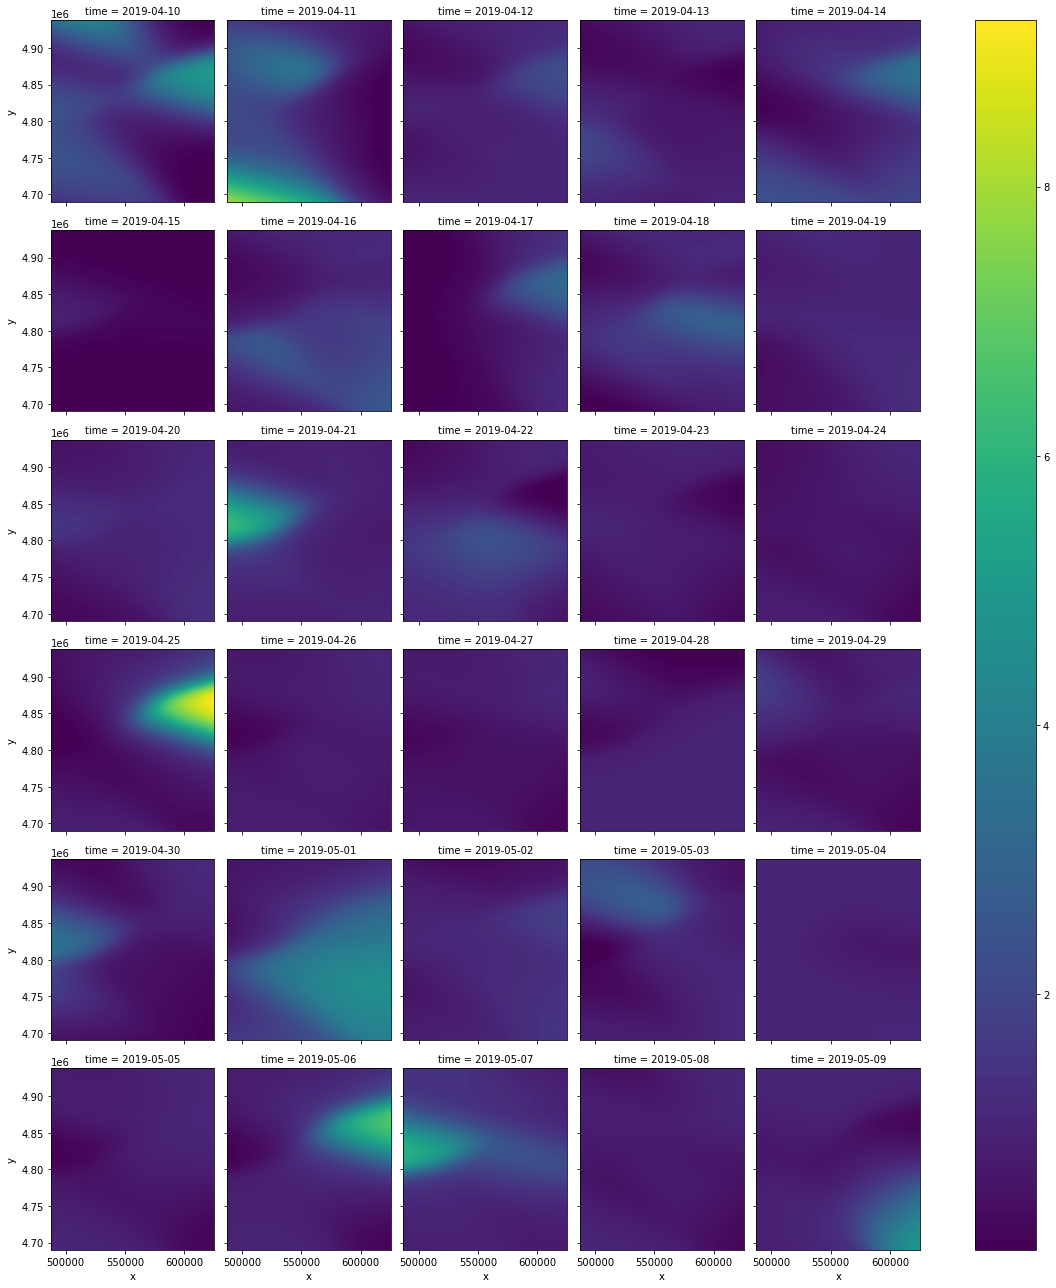

In [68]:
times = pd.date_range('2019-04-10', periods=30)
slicecor = SMswe_corr.sel(time=times)
slicecor.plot(x="x", y="y", col="time",col_wrap=5)

In [49]:
#get the correction factor at each CSO point  
cf =[]
for i in range(len(inobs)):
    cf.append(float(SMswe_corr.sel(y=inobs.geometry.y.values[i],
                             x=inobs.geometry.x.values[i],
                             time=CSO_gdf.dt.values[i],method='nearest').values))
    
CSO_gdf['cf']=cf
CSO_gdf

,Unnamed: 0,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,...,M,D,LON,LAT,H,swe,doy,cf,SMswe,bias
0,135,POINT (-110.597818510855 43.6701724330154),D3gyiOmE,Katie O’Connell,10.00,MountainHub,2019-04-25T02:25:30.037Z,2131.137695,452,1023,...,4,25,-110.597819,43.670172,100.0,0.033626,207,0.601282,0.0,0.0336256
1,136,POINT (-110.598540829639 43.6706713863815),SEJG7WBM,Katie O’Connell,72.00,MountainHub,2019-04-25T02:24:32.498Z,2127.995361,451,1023,...,4,25,-110.598541,43.670671,720.0,0.245734,207,0.598549,0.0,0.245734
2,137,POINT (-110.593582727118 43.6701536877488),Vn9QgQA7,Leanne,27.94,MountainHub,2019-04-24T15:56:24.335Z,2146.224609,455,1023,...,4,24,-110.593583,43.670154,279.4,0.094851,206,0.618180,0.0,0.0948508
3,138,POINT (-110.591223958083 43.670516817875),xlFXLIST,Leanne,25.40,MountainHub,2019-04-24T15:53:28.932Z,2156.758057,457,1023,...,4,24,-110.591224,43.670517,254.0,0.086550,206,0.618604,0.01654083,0.0700091
4,139,POINT (-110.598580352962 43.667640969849),4EMEMrPA,Colton Lewer,60.00,MountainHub,2019-04-24T15:53:19.864Z,2188.988770,451,1026,...,4,24,-110.598580,43.667641,600.0,0.203867,206,0.617558,0.058324937,0.145542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,440,POINT (-110.941374 43.789676),RlB3wF6G,Fred Most,56.00,SnowPilot,2018-11-12T16:39:00.000Z,2760.414795,175,891,...,11,12,-110.941374,43.789676,560.0,0.117115,43,0.100000,0.085047714,0.0320676
306,441,POINT (-110.95167 43.478566),6+xKcZFv,Chris McCollister,68.00,SnowPilot,2018-11-09T00:20:00.000Z,2794.276123,167,1237,...,11,9,-110.951670,43.478566,680.0,0.137963,40,0.351361,0.10334276,0.0346205
307,442,POINT (-110.850197 43.605528),7MKrMQAz,Josh Pope,95.00,SnowPilot,2018-11-08T17:30:00.000Z,2773.990234,248,1096,...,11,8,-110.850197,43.605528,950.0,0.193702,39,3.676730,0.11430374,0.0793987
308,443,POINT (-110.855482 43.602289),BBqIOtV3,Mike Rheam,65.00,SnowPilot,2018-11-08T17:00:00.000Z,2794.865967,244,1099,...,11,8,-110.855482,43.602289,650.0,0.134792,39,3.677830,0.11874233,0.0160495


In [21]:
#baseline SM run
numpy_data = get_mod_output(swe_base,num_timesteps,ny,nx)
time = pd.date_range(st, periods=num_timesteps) # periods=num_mod_timesteps
# convert to xarray DataArray
SMswe_base = xr.DataArray(
    numpy_data,
    dims=('time', 'y', 'x'), 
    coords={'time': time, 'y': np.flip(da.y.values), 'x': da.x.values}
)

In [22]:
#assilmilate snotel
numpy_data = get_mod_output(swe_base_snotel,num_timesteps,ny,nx)
time = pd.date_range(st, periods=num_timesteps) # periods=num_mod_timesteps
# convert to xarray DataArray
SMswe_snotel = xr.DataArray(
    numpy_data,
    dims=('time', 'y', 'x'), 
    coords={'time': time, 'y': np.flip(da.y.values), 'x': da.x.values}
)

In [23]:
# get the swe at the timestep corresponding to each snotel measurement
smswe =[]
for i in range(len(inobs)):
    smswe.append(SMswe_base.sel(y=inobs.geometry.y.values[i],
                             x=inobs.geometry.x.values[i],
                             time=CSO_gdf.dt.values[i],method='nearest').values)
# calculate the SWE bias     
CSO_gdf['SMswe']=smswe
CSO_gdf['bias'] = CSO_gdf.swe-CSO_gdf.SMswe
CSO_gdf

,Unnamed: 0,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,...,M,D,LON,LAT,H,swe,doy,cf,SMswe,bias
0,135,POINT (-110.597818510855 43.6701724330154),D3gyiOmE,Katie O’Connell,10.00,MountainHub,2019-04-25T02:25:30.037Z,2131.137695,452,1023,...,4,25,-110.597819,43.670172,100.0,0.033626,207,0.6012819,0.0,0.0336256
1,136,POINT (-110.598540829639 43.6706713863815),SEJG7WBM,Katie O’Connell,72.00,MountainHub,2019-04-25T02:24:32.498Z,2127.995361,451,1023,...,4,25,-110.598541,43.670671,720.0,0.245734,207,0.5985494,0.0,0.245734
2,137,POINT (-110.593582727118 43.6701536877488),Vn9QgQA7,Leanne,27.94,MountainHub,2019-04-24T15:56:24.335Z,2146.224609,455,1023,...,4,24,-110.593583,43.670154,279.4,0.094851,206,0.61818045,0.0,0.0948508
3,138,POINT (-110.591223958083 43.670516817875),xlFXLIST,Leanne,25.40,MountainHub,2019-04-24T15:53:28.932Z,2156.758057,457,1023,...,4,24,-110.591224,43.670517,254.0,0.086550,206,0.61860377,0.01654083,0.0700091
4,139,POINT (-110.598580352962 43.667640969849),4EMEMrPA,Colton Lewer,60.00,MountainHub,2019-04-24T15:53:19.864Z,2188.988770,451,1026,...,4,24,-110.598580,43.667641,600.0,0.203867,206,0.6175579,0.058324937,0.145542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,440,POINT (-110.941374 43.789676),RlB3wF6G,Fred Most,56.00,SnowPilot,2018-11-12T16:39:00.000Z,2760.414795,175,891,...,11,12,-110.941374,43.789676,560.0,0.117115,43,0.1,0.085047714,0.0320676
306,441,POINT (-110.95167 43.478566),6+xKcZFv,Chris McCollister,68.00,SnowPilot,2018-11-09T00:20:00.000Z,2794.276123,167,1237,...,11,9,-110.951670,43.478566,680.0,0.137963,40,0.35136086,0.10334276,0.0346205
307,442,POINT (-110.850197 43.605528),7MKrMQAz,Josh Pope,95.00,SnowPilot,2018-11-08T17:30:00.000Z,2773.990234,248,1096,...,11,8,-110.850197,43.605528,950.0,0.193702,39,3.6767302,0.11430374,0.0793987
308,443,POINT (-110.855482 43.602289),BBqIOtV3,Mike Rheam,65.00,SnowPilot,2018-11-08T17:00:00.000Z,2794.865967,244,1099,...,11,8,-110.855482,43.602289,650.0,0.134792,39,3.6778295,0.11874233,0.0160495


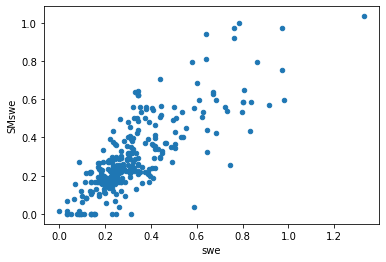

In [24]:
bx = CSO_gdf.plot(kind='scatter', x='swe',y='SMswe')

In [25]:
min(CSO_gdf.bias.values),max(CSO_gdf.bias.values)

(-0.30927261900674236, 0.5529268235662018)

In [ ]:
CSO_gdf[CSO_gdf.cf>10]

In [ ]:
CSO_gdf[CSO_gdf.cf<.2]

In [ ]:
fix = CSO_gdf[(CSO_gdf.bias<.2)&(CSO_gdf.bias>-.2)]

# snotel

In [26]:
#all snotel 
gdf = gpd.read_file('/nfs/attic/dfh/Aragon2/CSOdata/'+domain+'/CSO_SNOTEL_sites.geojson')
# projection
mod_proj = domains[domain]['mod_proj']
snotel=gdf.to_crs(mod_proj)
snotel.head()

,code,longitude,latitude,name,elevation_m,easting,northing,geometry
0,314_WY_SNTL,-110.445442,43.940189,Base Camp,2151.887939453125,544505.845453,4.865379e+06,POINT (544505.845 4865379.298)
1,347_MT_SNTL,-111.128029,44.508320,Black Bear,2490.216064453125,489823.440274,4.928341e+06,POINT (489823.440 4928341.300)
2,350_WY_SNTL,-109.793327,44.376671,Blackwater,2980.944091796875,596129.923439,4.914418e+06,POINT (596129.923 4914418.231)
3,353_WY_SNTL,-110.609734,42.964001,Blind Bull Sum,2636.52001953125,531828.554679,4.756891e+06,POINT (531828.555 4756891.027)
4,419_WY_SNTL,-110.814819,42.645901,Cottonwood Creek,2337.81591796875,515180.157295,4.721511e+06,POINT (515180.157 4721510.514)


In [ ]:
#get swe timeseries from xarray
i=0
SMswe_base.sel(y=snotel.geometry.y.values[i],x=snotel.geometry.x.values[i],method='nearest').values

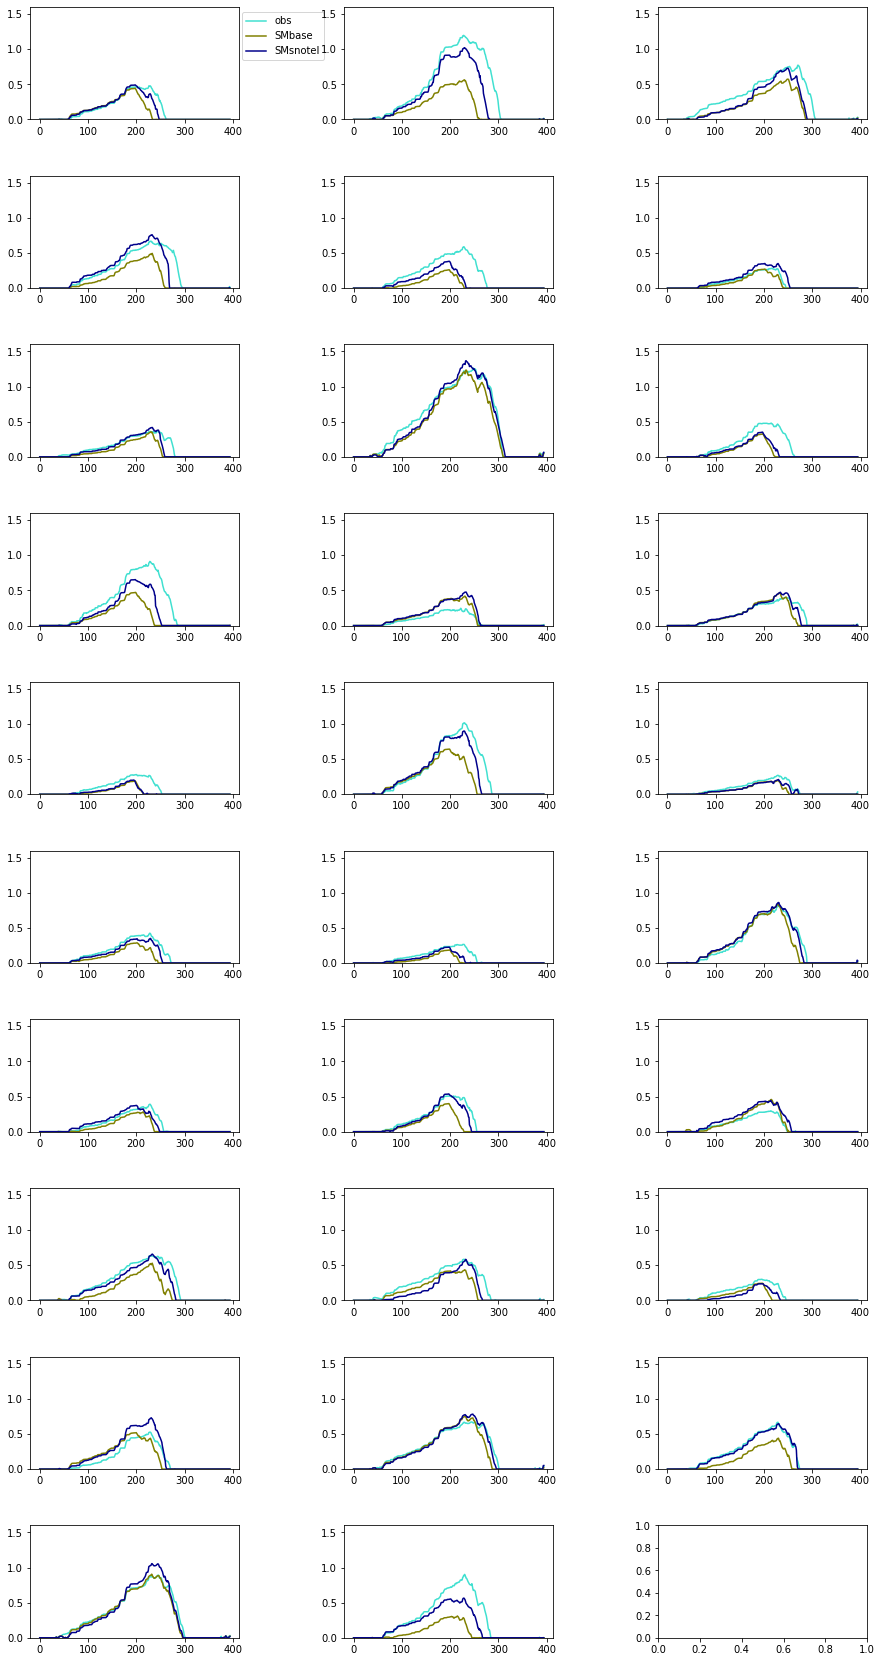

In [27]:
#assim_stn = assim_gdf.code.values

#WY: nrows=10,figsize=(15, 30); 
#CA: nrows=8,figsize=(15, 24); 
#OR: nrows=4, figsize=(15, 15); 
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
fig, axs = plt.subplots(nrows=10,figsize=(15, 30), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.flatten()

for i in range(len(snotel)):
    nam = snotel.code[i]
#     if any(nam in s for s in assim_stn):
#         color = 'r'
#     else:
#         color = 'k'
    swe_mod_snotel = SMswe_snotel.sel(y=snotel.geometry.y.values[i],x=snotel.geometry.x.values[i],method='nearest').values
    swe_mod_base = SMswe_base.sel(y=snotel.geometry.y.values[i],x=snotel.geometry.x.values[i],method='nearest').values
    swe_obs = swe_snotel[nam]
#     swe_stats_cso = calc_metrics(swe_mod_cso,swe_obs.values)
#     swe_stats_snotel = calc_metrics(swe_mod_snotel,swe_obs.values)
#     swe_stats_base = calc_metrics(swe_mod_base,swe_obs.values)
#     axs[i].text(1.3, .3, 'NSE_baseSM: '+str("{:.2f}".format(swe_stats_base[3]))+'\n'
#              +'NSE_snotel: '+str("{:.2f}".format(swe_stats_snotel[3]))+'\n'
#              +'NSE_cso: '+str("{:.2f}".format(swe_stats_cso[3])) , fontsize=10,color = color)
    axs[i].plot(swe_obs,label = 'obs', color = 'turquoise')
    axs[i].plot(swe_mod_base,label='SMbase',color = 'olive')
    axs[i].plot(swe_mod_snotel,label='SMsnotel',color = 'darkblue')
#     axs[i].plot(swe_mod_cso,label='mod_cso',color = 'sienna')
#     axs[i].set_title('NSE baseSM, snotel, cso:'+str("{:.2f}".format(swe_stats_base[3]))
#              +', '+str("{:.2f}".format(swe_stats_snotel[3]))
#              +', '+str("{:.2f}".format(swe_stats_cso[3])) , fontsize=10,color = color)
    axs[i].set_ylim([0, 1.6])
    if i == 0:
        axs[i].legend(bbox_to_anchor=(.99, 1), loc='upper left',)  
    

In [28]:
# create data array with temporally spaced out CSO observations
lowelbias = assimPath+'CSO_assim_2018-2019_all_lowelevbias.csv'
leb = pd.read_csv(lowelbias)
leb

,Unnamed: 0,Unnamed: 0.1,geometry,id,author,depth,source,timestamp,elevation,x,...,lc,dt,Y,M,D,LON,LAT,H,swe,doy
0,0,87,POINT (-110.597818510855 43.6701724330154),D3gyiOmE,Katie O’Connell,10.00,MountainHub,2019-04-25T02:25:30.037Z,2131.137695,532422.643976,...,6.0,2019-04-25,2019,4,25,-110.597819,43.670172,100.0,0.033626,207
1,1,88,POINT (-110.598540829639 43.6706713863815),SEJG7WBM,Katie O’Connell,72.00,MountainHub,2019-04-25T02:24:32.498Z,2127.995361,532364.144681,...,6.0,2019-04-25,2019,4,25,-110.598541,43.670671,720.0,0.245734,207
2,2,89,POINT (-110.593582727118 43.6701536877488),Vn9QgQA7,Leanne,27.94,MountainHub,2019-04-24T15:56:24.335Z,2146.224609,532764.130403,...,2.0,2019-04-24,2019,4,24,-110.593583,43.670154,279.4,0.094851,206
3,3,90,POINT (-110.591223958083 43.670516817875),xlFXLIST,Leanne,25.40,MountainHub,2019-04-24T15:53:28.932Z,2156.758057,532954.088693,...,1.0,2019-04-24,2019,4,24,-110.591224,43.670517,254.0,0.086550,206
4,4,91,POINT (-110.598580352962 43.667640969849),4EMEMrPA,Colton Lewer,60.00,MountainHub,2019-04-24T15:53:19.864Z,2188.988770,532362.586657,...,1.0,2019-04-24,2019,4,24,-110.598580,43.667641,600.0,0.203867,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,281,368,POINT (-110.870306 43.590676),8qzaI9zc,Cody McInnes,140.00,SnowPilot,2018-12-05T19:40:00.000Z,2918.032715,510469.320448,...,6.0,2018-12-05,2018,12,5,-110.870306,43.590676,1400.0,0.344194,66
120,303,390,POINT (-110.010724 43.733182),53nEfN14,Chris McCollister,46.00,SnowPilot,2018-11-14T23:00:00.000Z,2847.268799,579669.081469,...,1.0,2018-11-14,2018,11,14,-110.010724,43.733182,460.0,0.096710,45
121,306,393,POINT (-110.95167 43.478566),6+xKcZFv,Chris McCollister,68.00,SnowPilot,2018-11-09T00:20:00.000Z,2794.276123,503908.588273,...,1.0,2018-11-09,2018,11,9,-110.951670,43.478566,680.0,0.137963,40
122,307,394,POINT (-110.850197 43.605528),7MKrMQAz,Josh Pope,95.00,SnowPilot,2018-11-08T17:30:00.000Z,2773.990234,512089.610379,...,6.0,2018-11-08,2018,11,8,-110.850197,43.605528,950.0,0.193702,39


In [50]:
final = CSO_gdf[CSO_gdf.id.isin(leb.id.values).values]
final

,Unnamed: 0,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,...,M,D,LON,LAT,H,swe,doy,cf,SMswe,bias
0,135,POINT (-110.597818510855 43.6701724330154),D3gyiOmE,Katie O’Connell,10.00,MountainHub,2019-04-25T02:25:30.037Z,2131.137695,452,1023,...,4,25,-110.597819,43.670172,100.0,0.033626,207,0.601282,0.0,0.0336256
1,136,POINT (-110.598540829639 43.6706713863815),SEJG7WBM,Katie O’Connell,72.00,MountainHub,2019-04-25T02:24:32.498Z,2127.995361,451,1023,...,4,25,-110.598541,43.670671,720.0,0.245734,207,0.598549,0.0,0.245734
2,137,POINT (-110.593582727118 43.6701536877488),Vn9QgQA7,Leanne,27.94,MountainHub,2019-04-24T15:56:24.335Z,2146.224609,455,1023,...,4,24,-110.593583,43.670154,279.4,0.094851,206,0.618180,0.0,0.0948508
3,138,POINT (-110.591223958083 43.670516817875),xlFXLIST,Leanne,25.40,MountainHub,2019-04-24T15:53:28.932Z,2156.758057,457,1023,...,4,24,-110.591224,43.670517,254.0,0.086550,206,0.618604,0.01654083,0.0700091
4,139,POINT (-110.598580352962 43.667640969849),4EMEMrPA,Colton Lewer,60.00,MountainHub,2019-04-24T15:53:19.864Z,2188.988770,451,1026,...,4,24,-110.598580,43.667641,600.0,0.203867,206,0.617558,0.058324937,0.145542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,416,POINT (-110.870306 43.590676),8qzaI9zc,Cody McInnes,140.00,SnowPilot,2018-12-05T19:40:00.000Z,2918.032715,232,1112,...,12,5,-110.870306,43.590676,1400.0,0.344194,66,0.258239,0.25380206,0.090392
303,438,POINT (-110.010724 43.733182),53nEfN14,Chris McCollister,46.00,SnowPilot,2018-11-14T23:00:00.000Z,2847.268799,924,949,...,11,14,-110.010724,43.733182,460.0,0.096710,45,1.000000,0.06411318,0.0325969
306,441,POINT (-110.95167 43.478566),6+xKcZFv,Chris McCollister,68.00,SnowPilot,2018-11-09T00:20:00.000Z,2794.276123,167,1237,...,11,9,-110.951670,43.478566,680.0,0.137963,40,0.351361,0.10334276,0.0346205
307,442,POINT (-110.850197 43.605528),7MKrMQAz,Josh Pope,95.00,SnowPilot,2018-11-08T17:30:00.000Z,2773.990234,248,1096,...,11,8,-110.850197,43.605528,950.0,0.193702,39,3.676730,0.11430374,0.0793987


In [51]:
min(final.bias.values),max(final.bias.values)

(-0.26465087454614133, 0.49058995977621067)

In [52]:
min(final.cf.values),max(final.cf.values)

(0.10000000149011612, 25.839797973632812)

In [53]:
final.cf.values

array([ 0.60128188,  0.59854943,  0.61818045,  0.61860377,  0.61755788,
        0.61818045,  0.61761093,  0.6175459 ,  0.61761093,  0.61796892,
        0.6175459 ,  0.61796892,  0.6175459 ,  0.61747241,  0.61796892,
        0.61761987,  0.61796892,  0.61747241,  4.64983177,  1.02319932,
        0.29764539,  0.80899769,  0.80787039,  0.8059386 ,  0.81002527,
        0.80476165,  0.81093818,  0.81093818,  0.81093818,  0.81093818,
        0.80849171,  0.81093818,  0.81305897,  0.82208622,  0.81431699,
        0.81501245,  0.81093818,  0.82348502,  0.81093818,  0.81501245,
        0.81375587,  0.81093818,  0.82291019,  0.81445801,  0.81093818,
        0.81320989,  0.80787039,  0.82362485,  0.82634795,  0.81093818,
        0.80787039,  0.81391907,  0.82380044,  0.82307291,  0.81093818,
        0.81267887,  0.82380044,  0.82054818,  0.81339538,  0.81093818,
        0.81216365,  0.81216365,  0.81093818,  0.81093818,  0.81093818,
        0.81093818,  0.81361556,  0.81044561,  0.81044561,  0.22

In [54]:
final.bias.values

array([0.033625600838021484, 0.2457340046514937, 0.0948508125594754,
       0.07000907916542413, 0.14554174909661252, 0.09482340382098604,
       0.135825676025469, 0.051351333722476813, 0.15294286949221447,
       0.0860152284375484, 0.07723022596350973, 0.15549563368875755,
       0.2282470077149375, 0.13575475090130867, 0.13802678237819258,
       0.22468477244953533, 0.08598030872278085, 0.10837697571698307,
       0.3118533882143029, 0.031896345164189134, -0.11414801772861091,
       0.10068044051086339, 0.07664100735741766, 0.06722764012924232,
       -0.043035710713346886, 0.0077723097645170935, 0.05903474822060409,
       0.07593505116644556, 0.06241405799516739, 0.05903474822060409,
       0.01910860559960914, -0.05559764921903387, 0.030920568214951205,
       -0.12102006462414286, -0.027323043472643804, 0.04339728290899869,
       0.0387671009808605, -0.14052148259987723, 0.05565582210444145,
       0.49058995977621067, -0.020091996387405553, 0.05565582210444145,
       -0.03

In [56]:
fix = final[(final.bias<.2)&(final.bias>-.2)]
fix

,Unnamed: 0,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,...,M,D,LON,LAT,H,swe,doy,cf,SMswe,bias
0,135,POINT (-110.597818510855 43.6701724330154),D3gyiOmE,Katie O’Connell,10.00,MountainHub,2019-04-25T02:25:30.037Z,2131.137695,452,1023,...,4,25,-110.597819,43.670172,100.0,0.033626,207,0.601282,0.0,0.0336256
2,137,POINT (-110.593582727118 43.6701536877488),Vn9QgQA7,Leanne,27.94,MountainHub,2019-04-24T15:56:24.335Z,2146.224609,455,1023,...,4,24,-110.593583,43.670154,279.4,0.094851,206,0.618180,0.0,0.0948508
3,138,POINT (-110.591223958083 43.670516817875),xlFXLIST,Leanne,25.40,MountainHub,2019-04-24T15:53:28.932Z,2156.758057,457,1023,...,4,24,-110.591224,43.670517,254.0,0.086550,206,0.618604,0.01654083,0.0700091
4,139,POINT (-110.598580352962 43.667640969849),4EMEMrPA,Colton Lewer,60.00,MountainHub,2019-04-24T15:53:19.864Z,2188.988770,451,1026,...,4,24,-110.598580,43.667641,600.0,0.203867,206,0.617558,0.058324937,0.145542
5,140,POINT (-110.593851870029 43.6706280196492),z9fBqWhi,Leanne,27.94,MountainHub,2019-04-24T15:51:00.335Z,2148.117920,455,1023,...,4,24,-110.593852,43.670628,279.4,0.094823,206,0.618180,0.0,0.0948234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,416,POINT (-110.870306 43.590676),8qzaI9zc,Cody McInnes,140.00,SnowPilot,2018-12-05T19:40:00.000Z,2918.032715,232,1112,...,12,5,-110.870306,43.590676,1400.0,0.344194,66,0.258239,0.25380206,0.090392
303,438,POINT (-110.010724 43.733182),53nEfN14,Chris McCollister,46.00,SnowPilot,2018-11-14T23:00:00.000Z,2847.268799,924,949,...,11,14,-110.010724,43.733182,460.0,0.096710,45,1.000000,0.06411318,0.0325969
306,441,POINT (-110.95167 43.478566),6+xKcZFv,Chris McCollister,68.00,SnowPilot,2018-11-09T00:20:00.000Z,2794.276123,167,1237,...,11,9,-110.951670,43.478566,680.0,0.137963,40,0.351361,0.10334276,0.0346205
307,442,POINT (-110.850197 43.605528),7MKrMQAz,Josh Pope,95.00,SnowPilot,2018-11-08T17:30:00.000Z,2773.990234,248,1096,...,11,8,-110.850197,43.605528,950.0,0.193702,39,3.676730,0.11430374,0.0793987


In [58]:
fixx = final[(final.cf<4)&(final.cf>.2)]
fixx

,Unnamed: 0,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,...,M,D,LON,LAT,H,swe,doy,cf,SMswe,bias
0,135,POINT (-110.597818510855 43.6701724330154),D3gyiOmE,Katie O’Connell,10.00,MountainHub,2019-04-25T02:25:30.037Z,2131.137695,452,1023,...,4,25,-110.597819,43.670172,100.0,0.033626,207,0.601282,0.0,0.0336256
1,136,POINT (-110.598540829639 43.6706713863815),SEJG7WBM,Katie O’Connell,72.00,MountainHub,2019-04-25T02:24:32.498Z,2127.995361,451,1023,...,4,25,-110.598541,43.670671,720.0,0.245734,207,0.598549,0.0,0.245734
2,137,POINT (-110.593582727118 43.6701536877488),Vn9QgQA7,Leanne,27.94,MountainHub,2019-04-24T15:56:24.335Z,2146.224609,455,1023,...,4,24,-110.593583,43.670154,279.4,0.094851,206,0.618180,0.0,0.0948508
3,138,POINT (-110.591223958083 43.670516817875),xlFXLIST,Leanne,25.40,MountainHub,2019-04-24T15:53:28.932Z,2156.758057,457,1023,...,4,24,-110.591224,43.670517,254.0,0.086550,206,0.618604,0.01654083,0.0700091
4,139,POINT (-110.598580352962 43.667640969849),4EMEMrPA,Colton Lewer,60.00,MountainHub,2019-04-24T15:53:19.864Z,2188.988770,451,1026,...,4,24,-110.598580,43.667641,600.0,0.203867,206,0.617558,0.058324937,0.145542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,402,POINT (-110.956677397427 43.4903585762273),aOiee7Ac,michael mourar,83.00,MountainHub,2018-12-10T01:11:16.781Z,2658.399170,163,1224,...,12,10,-110.956677,43.490359,830.0,0.206343,71,0.867098,0.1877028,0.0186402
281,416,POINT (-110.870306 43.590676),8qzaI9zc,Cody McInnes,140.00,SnowPilot,2018-12-05T19:40:00.000Z,2918.032715,232,1112,...,12,5,-110.870306,43.590676,1400.0,0.344194,66,0.258239,0.25380206,0.090392
303,438,POINT (-110.010724 43.733182),53nEfN14,Chris McCollister,46.00,SnowPilot,2018-11-14T23:00:00.000Z,2847.268799,924,949,...,11,14,-110.010724,43.733182,460.0,0.096710,45,1.000000,0.06411318,0.0325969
306,441,POINT (-110.95167 43.478566),6+xKcZFv,Chris McCollister,68.00,SnowPilot,2018-11-09T00:20:00.000Z,2794.276123,167,1237,...,11,9,-110.951670,43.478566,680.0,0.137963,40,0.351361,0.10334276,0.0346205


In [59]:
fixx = fix[(fix.cf<4)&(fix.cf>.2)]
fixx

,Unnamed: 0,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,...,M,D,LON,LAT,H,swe,doy,cf,SMswe,bias
0,135,POINT (-110.597818510855 43.6701724330154),D3gyiOmE,Katie O’Connell,10.00,MountainHub,2019-04-25T02:25:30.037Z,2131.137695,452,1023,...,4,25,-110.597819,43.670172,100.0,0.033626,207,0.601282,0.0,0.0336256
2,137,POINT (-110.593582727118 43.6701536877488),Vn9QgQA7,Leanne,27.94,MountainHub,2019-04-24T15:56:24.335Z,2146.224609,455,1023,...,4,24,-110.593583,43.670154,279.4,0.094851,206,0.618180,0.0,0.0948508
3,138,POINT (-110.591223958083 43.670516817875),xlFXLIST,Leanne,25.40,MountainHub,2019-04-24T15:53:28.932Z,2156.758057,457,1023,...,4,24,-110.591224,43.670517,254.0,0.086550,206,0.618604,0.01654083,0.0700091
4,139,POINT (-110.598580352962 43.667640969849),4EMEMrPA,Colton Lewer,60.00,MountainHub,2019-04-24T15:53:19.864Z,2188.988770,451,1026,...,4,24,-110.598580,43.667641,600.0,0.203867,206,0.617558,0.058324937,0.145542
5,140,POINT (-110.593851870029 43.6706280196492),z9fBqWhi,Leanne,27.94,MountainHub,2019-04-24T15:51:00.335Z,2148.117920,455,1023,...,4,24,-110.593852,43.670628,279.4,0.094823,206,0.618180,0.0,0.0948234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,402,POINT (-110.956677397427 43.4903585762273),aOiee7Ac,michael mourar,83.00,MountainHub,2018-12-10T01:11:16.781Z,2658.399170,163,1224,...,12,10,-110.956677,43.490359,830.0,0.206343,71,0.867098,0.1877028,0.0186402
281,416,POINT (-110.870306 43.590676),8qzaI9zc,Cody McInnes,140.00,SnowPilot,2018-12-05T19:40:00.000Z,2918.032715,232,1112,...,12,5,-110.870306,43.590676,1400.0,0.344194,66,0.258239,0.25380206,0.090392
303,438,POINT (-110.010724 43.733182),53nEfN14,Chris McCollister,46.00,SnowPilot,2018-11-14T23:00:00.000Z,2847.268799,924,949,...,11,14,-110.010724,43.733182,460.0,0.096710,45,1.000000,0.06411318,0.0325969
306,441,POINT (-110.95167 43.478566),6+xKcZFv,Chris McCollister,68.00,SnowPilot,2018-11-09T00:20:00.000Z,2794.276123,167,1237,...,11,9,-110.951670,43.478566,680.0,0.137963,40,0.351361,0.10334276,0.0346205


In [62]:
fixx.cf.values

array([0.60128188, 0.61818045, 0.61860377, 0.61755788, 0.61818045,
       0.61761093, 0.6175459 , 0.61761093, 0.61796892, 0.6175459 ,
       0.61796892, 0.61747241, 0.61796892, 0.61796892, 0.61747241,
       1.02319932, 0.29764539, 0.80899769, 0.80787039, 0.8059386 ,
       0.81002527, 0.80476165, 0.81093818, 0.81093818, 0.81093818,
       0.81093818, 0.80849171, 0.81093818, 0.81305897, 0.82208622,
       0.81431699, 0.81501245, 0.81093818, 0.82348502, 0.81093818,
       0.81375587, 0.81093818, 0.82291019, 0.81445801, 0.81093818,
       0.81320989, 0.80787039, 0.82362485, 0.82634795, 0.81093818,
       0.80787039, 0.81391907, 0.82380044, 0.82307291, 0.81093818,
       0.81267887, 0.82380044, 0.82054818, 0.81339538, 0.81093818,
       0.81216365, 0.81216365, 0.81093818, 0.81093818, 0.81093818,
       0.81093818, 0.81361556, 0.81044561, 0.81044561, 0.22318488,
       0.41980582, 0.85730755, 1.96151829, 1.09333217, 0.67958629,
       3.87646055, 3.88477373, 1.00463343, 1.00321019, 2.01792

In [64]:
fixx.to_csv('fixx.csv')

In [65]:
final.to_csv('fix.csv')